# Understanding Bayesian Optimization

A simple worked through example of using BO to find the minimum of a one dimensional function

The majority of this is taken from  *Gaussian processes for machine learning* by C. E. Rasmussen and C. K. I. Williams.


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)

### Target function and input domain

We start by defning the target funtion and generating the input domain, x_true 

Text(0.5,0,u'x')

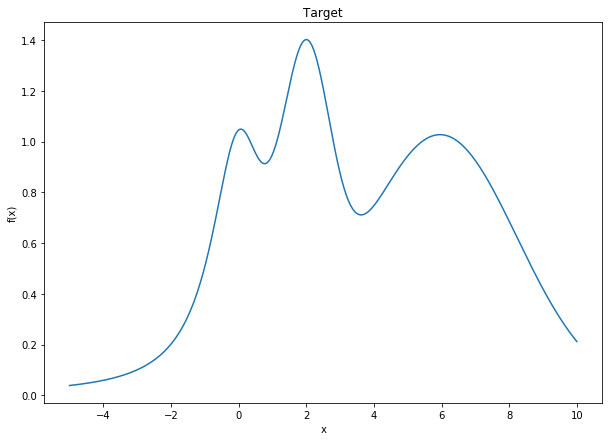

In [3]:
# Define the function we're trying to minimize 
# def f(x):
#     return x**2

def f(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

# define a set of measurmenets
min_x,max_x, n_samples = -5,10,4
# True distirubtuion
X_true =  np.linspace(min_x,max_x,1000) 
f_x_true = [f(x) for x in X_true]

# PSeudo data, we made n_sample measurements
plt.plot(X_true,f_x_true)
plt.title('Target')
plt.ylabel('f(x)')
plt.xlabel('x')

## Visualizing samples from a Gaussian process

We need to first define a kernel,or covariance, between the a test set of inputs X_test. We are going to first draw a few lines

Then we're going to draw samples of gaussian process given the conditional obserations already made  

In [52]:
def kernel(X,X_prime,l = 1.0):
    """
        The covariance or kernel of the gaussian processes used to minimize 
        this example
        
        Sometimes this covariance function is called the Radial Basis Function (RBF) or Gaussian;
        here we prefer squared exponential.
    """
    assert l != 0.0, "ERROR: the length scale must be non-zero"
    
    K =  []
    for i,x in enumerate(X):
        row = []
        for j,x_p in enumerate(X_prime):
            row.append( np.exp( -0.5*np .square( x - x_p )) )
        K.append( row  )
    return np.array(K)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


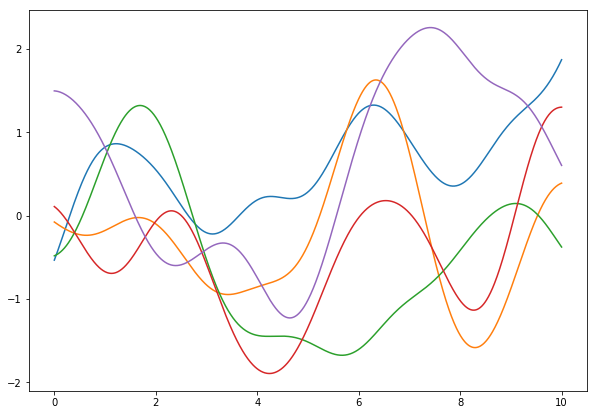

In [53]:
# Geneate the kernal matrix and cahce it so we don't run this costlye process every time 
Sigma =  kernel( X_true,X_true )

for n_examples in xrange(5): 
    plt.plot(X_true,np.random.multivariate_normal(np.zeros(len(X_true)), Sigma))
%time

## Evaluating the Postier: Conditional sampling from Gaussian process

We now want to evaluate a postierier distribution given our observation set X. From this we want to asses where is the next best choice for a new value 

In an optimization problem we would also wish to evaluate the acquisition, or utility, function. We're going to examine a function that's peak is where we have the biggest uncertainty about the model - the so called expected improvement acquisition funtion

In [54]:
def postierier(x,X,f_X):
    """ 
    The postier function given input:
        x: distibution in x to be tested over 
        X: measured X that will be integrated out 
        f_X: measured Y associated with each point x    
    """
    k_xX = kernel(x,X)
    k_XX = kernel(X,X)
    k_XX_inv = np.linalg.inv(k_XX)
    k_xx = kernel(x,x)
    k_Xx = kernel(X,x)
    
    mean = np.matmul(k_XX_inv,f_X )
    mean = np.matmul( k_xX, mean)

    sigma = np.matmul(k_XX_inv, k_Xx)
    sigma = np.matmul(k_xX, sigma)
    sigma = k_xx - sigma
    return mean, sigma

from scipy.stats import norm
def utility(x,f_x, m,sigma):
    """
        expected improvement acquisition 
        x:   Measured x values distribution
        f_X: Measured values of function we're trying to optimize
        m:   Mean value of the gaussian processes at each point in x-space
        sigma: width of the gaussians at each point in x-space
    """
    f_min = np.min(f_x)
    Z = np.divide( (-m  +f_min), sigma)
    return np.nan_to_num(np.multiply(-m+f_min,norm.cdf(f_min,m,sigma  )) + np.multiply(sigma, norm.pdf(Z) ))

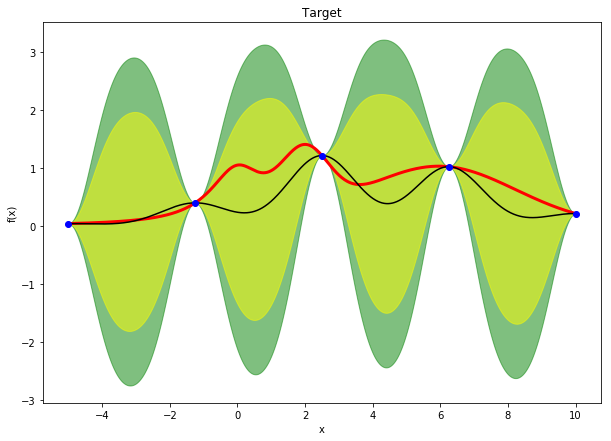

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in divide


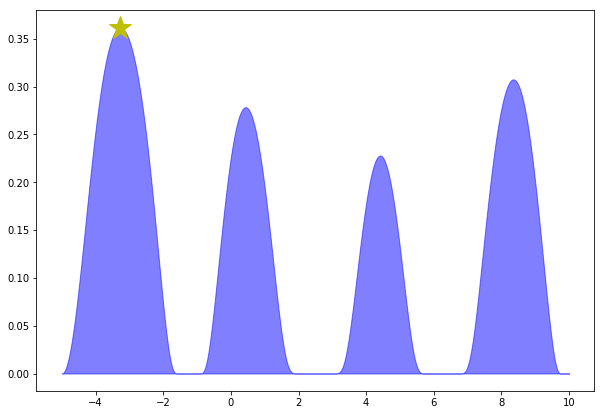

In [12]:
X =  np.linspace(min_x,max_x,5) 
f_X = [f(x) for x in X]

m, s = postierier(X_true, X,f_X ) 
sig = np.diag(s) 

# Draw the 3 sigma band of the postier distirbution
plt.fill_between(X_true, m - 3*sig, m+3*sig,alpha=0.5,color='green')
plt.fill_between(X_true, m - 2*sig, m+2*sig,alpha=0.5,color='yellow')

plt.plot(X_true,f_x_true,color='red',linewidth=3.0)
plt.title('Target')
plt.ylabel('f(x)')
plt.xlabel('x')

# sample and draw a few postieriers 
# for n_examples in xrange(1,3): 
#     plt.plot(X_true,np.random.multivariate_normal(m,s))
# Draw the means 
plt.plot(X_true,m,color = 'black')
plt.plot(X,f_X,'bo')
plt.show()

# Draw the utility function for the current postier 
u = utility(X,f_X, m, sig)
x_max, u_max = X_true[np.argmax(u)],np.max(u)
plt.fill_between(X_true, 0,u,alpha=0.5,color='blue')
plt.plot( [x_max],[u_max], 'y*',
          markersize=24)

## Performing an optimization

We now have the tools to implement an optimization so let's iterate through an optimization procedure

In [51]:
from copy import copy
class Iteration:
    def __init__(self, 
                 mean,
                 covariance, 
                 X,
                 f_X,
                 u 
                ):
        self.mean       = copy(mean)
        self.covariance = copy(covariance)
        self.sigma      = copy(np.diag(covariance))
        self.X          = copy(X)
        self.f_X        = copy(f_X)
        self.u          = copy(u)

def optimize(f,x_initial, x_range, stop_criteria=20):
    """
        Performs a bayesian optimziation procedure
    """
    # Rename the initial guesses to 
    # captal X which always represents the measured 
    # X points
    X = x_initial 
    f_X = [f(x) for x in X ]

    iterations = [] 
    # Keep evaluating until we've satisifed our finishing criteria
    for i in xrange(stop_criteria):
        print "Performing Iteration: ", i
            
        # Evaluate the postier, and get the mean and 
        # covariance matrix
        try:
            mean, covar = postierier(x_range, X,f_X ) 
        except:
            return iterations 
        
        # Evalaute the width at each point 
        sig = np.diag(covar) 

        # Draw the utility function for the current postier 
        u = utility(X,f_X, mean, sig)
        x_max, u_max = X_true[np.argmax(u)],np.max(u)
        print "  maximal utlity: ", u_max
        print "          next x: ", x_max
        
        # Add this iterations values to the store of them
        iterations.append( Iteration(mean,
                                    covar, 
                                    X,
                                    f_X,
                                    u ))
        # Update the list of measurements to include the next
        # best guess 
        X.append(x_max)
        f_X.append(f(x_max))
        
    return iterations

x_initial = [0] 
iterations = optimize( f, x_initial,np.linspace(0,10,1000),stop_criteria = 5)


Performing Iteration:  0


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in divide


  maximal utlity:  1.1142953659294408
          next x:  8.578578578578579
Performing Iteration:  1


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in divide


  maximal utlity:  0.7169993935099972
          next x:  4.374374374374375
Performing Iteration:  2
  maximal utlity:  0.6103683642696764
          next x:  6.566566566566567
Performing Iteration:  3
  maximal utlity:  0.6028669458088192
          next x:  2.2622622622622623
Performing Iteration:  4
  maximal utlity:  0.5649971737506598
          next x:  10.0


#### Draw the optimization

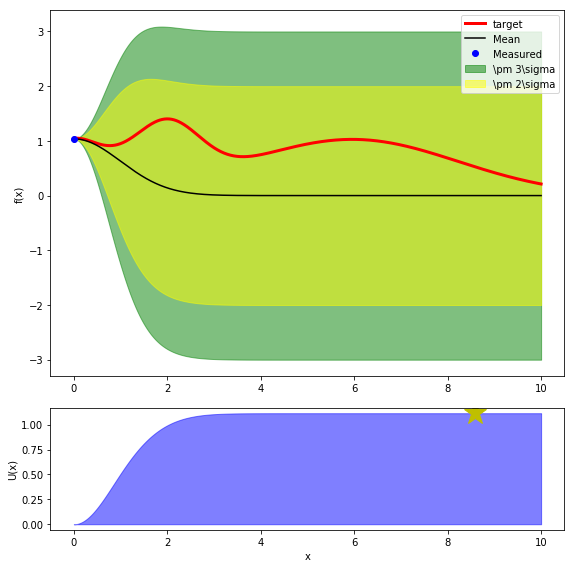

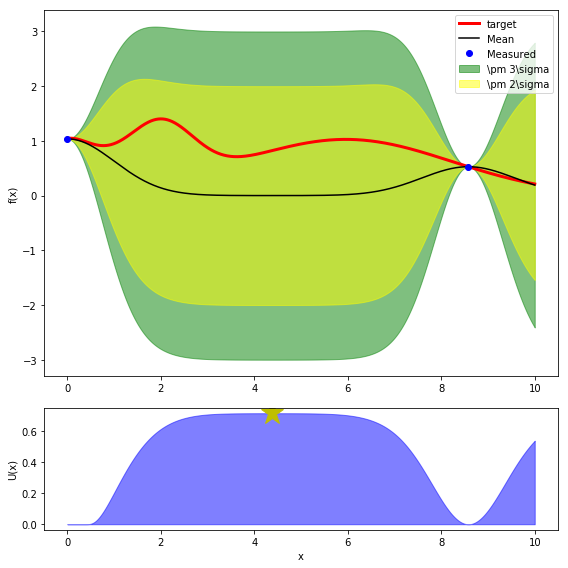

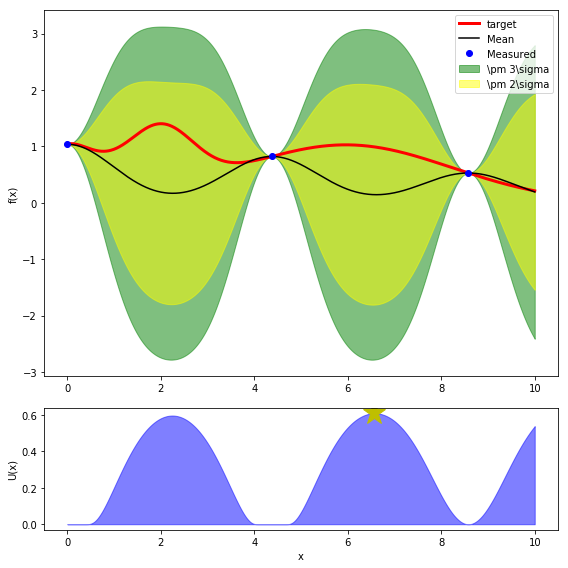

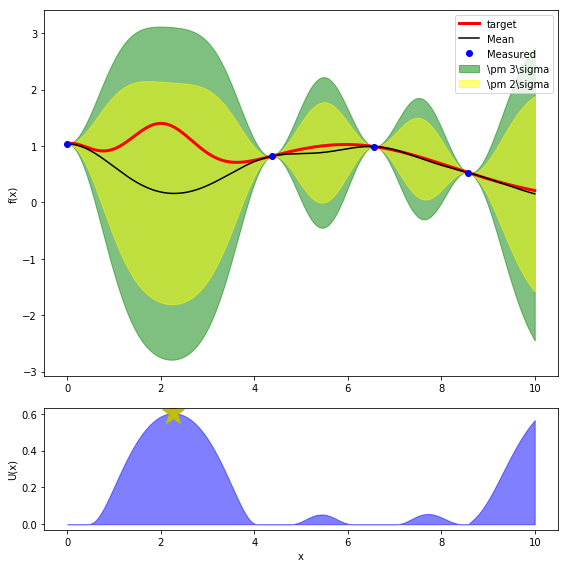

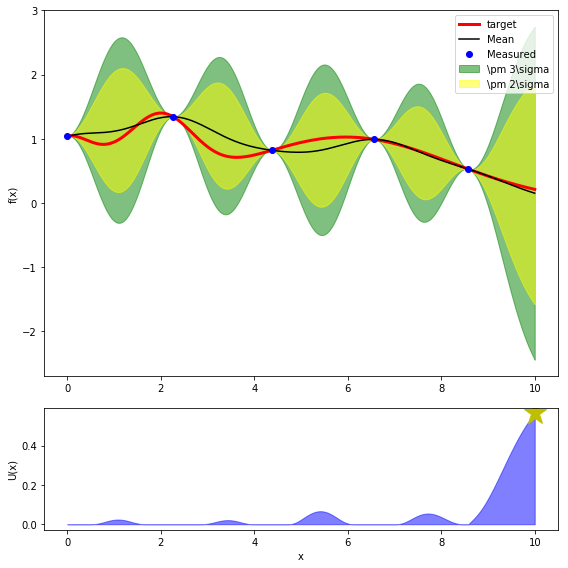

In [70]:
X_true = np.linspace(0,10,1000)
f_x_true = [f(x) for x in X_true ]
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('optimization_output.pdf') as pdf:
    for iteration in iterations:
        m   = iteration.mean 
        sig = iteration.sigma
        f_X = iteration.f_X 
        X   = iteration.X 

        # Setup a figure with an upper and lower pannel 
        fig = plt.figure(figsize=(8, 8)) 
        gs = gridspec.GridSpec(2, 1, width_ratios=[1],height_ratios=[3,1]) 
        ax0 = plt.subplot(gs[0])

        # Draw the upwer pannel
        ax0.fill_between(X_true, m - 3*sig, m+3*sig,alpha=0.5,color='green',label = r'\pm 3\sigma')
        ax0.fill_between(X_true, m - 2*sig, m+2*sig,alpha=0.5,color='yellow',label = r'\pm 2\sigma')

        ax0.plot(X_true,f_x_true,color='red',linewidth=3.0, label='target')
        ax0.set_ylabel('f(x)')

        ax0.plot(X_true,m,color = 'black', label='Mean')
        ax0.plot(X,f_X,'bo', label='Measured')
        ax0.legend()

        # Draw the utility function for the current postier 
        u = iteration.u
        x_max, u_max = X_true[np.argmax(u)],np.max(u)

        ax1 = plt.subplot(gs[1])
        ax1.fill_between(X_true, 0,u,alpha=0.5,color='blue')
        ax1.plot( [x_max],[u_max], 'y*',
                  markersize=24)
        ax1.set_xlabel('x')
        ax1.set_ylabel('U(x)')

        plt.tight_layout()
        plt.show()
        pdf.savefig(fig) 
        plt.close()
        
